<a href="https://colab.research.google.com/github/pren1/VAST/blob/master/Splitter_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# %tensorflow_version 1.x

In [0]:
!rm -rf VAST/
!git clone https://github.com/pren1/VAST.git
!pip3 install soundfile
!pip3 install librosa

Cloning into 'VAST'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 144 (delta 67), reused 66 (delta 24), pack-reused 0
Receiving objects: 100% (144/144), 45.18 MiB | 10.03 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [0]:
from VAST.util import *
import pdb
import pprint
from tqdm import tqdm
import numpy as np
import IPython
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
import os
from tqdm import trange

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

KeyboardInterrupt: ignored

In [0]:
# adapted from Keith Ito's tacotron implementation
# https://github.com/keithito/tacotron/blob/master/util/audio.py

import librosa
import numpy as np


class Audio():
    def __init__(self):
        self.ref_level_db = 20.0
        self.n_fft = 1200
        self.hop_length = 160
        self.win_length = 400
        self.min_level_db = -100.0

    def wav2spec(self, y):
        D = self.stft(y)
        S = self.amp_to_db(np.abs(D)) - self.ref_level_db
        S, D = self.normalize(S), np.angle(D)
        S, D = S.T, D.T # to make [time, freq]
        return S, D

    def spec2wav(self, spectrogram, phase):
        spectrogram, phase = spectrogram.T, phase.T
        # used during inference only
        # spectrogram: enhanced output
        # phase: use noisy input's phase, so no GLA is required
        S = self.db_to_amp(self.denormalize(spectrogram) + self.ref_level_db)
        return self.istft(S, phase)

    def stft(self, y):
        return librosa.stft(y=y, n_fft=self.n_fft,
                            hop_length=self.hop_length,
                            win_length=self.win_length)

    def istft(self, mag, phase):
        stft_matrix = mag * np.exp(1j*phase)
        return librosa.istft(stft_matrix,
                             hop_length=self.hop_length,
                             win_length=self.win_length)

    def amp_to_db(self, x):
        return 20.0 * np.log10(np.maximum(1e-5, x))

    def db_to_amp(self, x):
        return np.power(10.0, x * 0.05)

    def normalize(self, S):
        return np.clip(S / -self.min_level_db, -1.0, 0.0) + 1.0

    def denormalize(self, S):
        return (np.clip(S, 0.0, 1.0) - 1.0) * -self.min_level_db

audio = Audio()

In [0]:
import math
import tensorflow as tf

def trunk_network(conv_size = 64, LSTM_size = 400, input_size = (51, 601), dropout_rate = 0.0):
    inputs = tf.keras.layers.Input(input_size)
    x = tf.keras.layers.Reshape((input_size[0],  input_size[1], 1))(inputs)
    # cnn1
    x = tf.keras.layers.ZeroPadding2D(padding=((0, 0), (3, 3)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (1, 7))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # cnn2
    x = tf.keras.layers.ZeroPadding2D(padding=((3, 3), (0, 0)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (7, 1))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # cnn3
    x = tf.keras.layers.ZeroPadding2D(padding=((2, 2), (2, 2)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (5, 5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # cnn1
    x = tf.keras.layers.ZeroPadding2D(padding=((0, 0), (3, 3)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (1, 7))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # cnn2
    x = tf.keras.layers.ZeroPadding2D(padding=((3, 3), (0, 0)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (7, 1))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # cnn3
    x = tf.keras.layers.ZeroPadding2D(padding=((2, 2), (2, 2)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (5, 5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # # cnn3
    # x = tf.keras.layers.ZeroPadding2D(padding=((2, 2), (2, 2)))(x)
    # x = tf.keras.layers.Conv2D(conv_size, (5, 5))(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)
    # x = tf.keras.layers.Dropout(dropout_rate)(x)

    # # cnn3
    # x = tf.keras.layers.ZeroPadding2D(padding=((2, 2), (2, 2)))(x)
    # x = tf.keras.layers.Conv2D(conv_size, (5, 5))(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)
    # x = tf.keras.layers.Dropout(dropout_rate)(x)

    # # cnn3
    # x = tf.keras.layers.ZeroPadding2D(padding=((2, 2), (2, 2)))(x)
    # x = tf.keras.layers.Conv2D(conv_size, (5, 5))(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)
    # x = tf.keras.layers.Dropout(dropout_rate)(x)

    # # # cnn4
    # x = tf.keras.layers.ZeroPadding2D(padding=((4, 4), (2, 2)))(x)
    # x = tf.keras.layers.Conv2D(conv_size, (5, 5), dilation_rate=(2, 1))(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)

    # # cnn5
    # x = tf.keras.layers.ZeroPadding2D(padding=((8, 8), (2, 2)))(x)     
    # x = tf.keras.layers.Conv2D(conv_size, (5, 5), dilation_rate=(4, 1))(x)       
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)

    # # cnn6
    # x = tf.keras.layers.ZeroPadding2D(padding=((16, 16), (2, 2)))(x)                 
    # x = tf.keras.layers.Conv2D(conv_size, (5, 5), dilation_rate=(8, 1))(x) 
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)

    # # cnn7 TensorShape([None, 51, 601, conv_size])
    # x = tf.keras.layers.ZeroPadding2D(padding=((32, 32), (2, 2)))(x)
    # x = tf.keras.layers.Conv2D(conv_size, (5, 5), dilation_rate=(16, 1))(x)     
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)

    # cnn8 TensorShape([None, 51, 601, 8])
    x = tf.keras.layers.Conv2D(8, (1, 1))(x)     
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    'Reshape x shape TensorShape([None, 51, 4808])'
    # x = tf.keras.layers.Reshape((tf.keras.backend.int_shape(x)[1], tf.keras.backend.int_shape(x)[2]*tf.keras.backend.int_shape(x)[3]))(x)
    x = tf.keras.layers.Reshape((51, 4808))(x)

    # LSTM 1
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_size, return_sequences=True)
                            )(x)  # [b_s, seq_len, vec_dim]
    x = tf.keras.layers.Dropout(dropout_rate)(x)                        

    # # LSTM 2 TensorShape([None, 51, 800])                                           
    # x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_size, return_sequences=True)
    #                         )(x)  # [b_s, seq_len, vec_dim]

    x = tf.keras.layers.ReLU()(x)
    # Dense 1
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(input_size[1]))(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    # Dense 2
    mask = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(input_size[1], activation='sigmoid'))(x)

    output = tf.keras.layers.Multiply()([inputs, mask])
    # print(output.shape)
    model = tf.keras.Model(inputs=[inputs], outputs=[output])
    return model

'learning rate decay'
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate    

### Prepare data

In [0]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)
with strategy.scope():
  model = trunk_network(conv_size = 64, LSTM_size = 400)
  model.compile(optimizer=tf.keras.optimizers.Adam(0.005), loss=['mse'])
  lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

INFO:tensorflow:Initializing the TPU system: grpc://10.69.219.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.69.219.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 51, 601)]    0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 51, 601, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 51, 607, 1)   0           reshape[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 51, 601, 64)  512         zero_padding2d[0][0]             
______________________________________________________________________________________________

In [0]:
# X_total = []
# y_total = []

# for i in tqdm(range(67)):
#   X_total.append(np.load(f"gdrive/My Drive/Spitter_VTB/mixed_mag/{i}.npy", allow_pickle=True))
#   y_total.append(np.load(f"gdrive/My Drive/Spitter_VTB/target_mag/{i}.npy", allow_pickle=True))

In [0]:
# def mix(s1_target, s2):
#   srate = 8000
#   w1 = s1_target
#   w2 = s2

#   mixed = w1 + w2
#   norm = np.max(np.abs(mixed)) * 1.1
#   w1, w2, mixed = w1/norm, w2/norm, mixed/norm

#   target_mag, _ = audio.wav2spec(w1)
#   mixed_mag, mixed_phase = audio.wav2spec(mixed)
#   return target_mag, mixed_mag, mixed_phase

In [0]:
# import random

# def generate_data_on_the_fly(batch_size, spk1_source_data, spk2_source_data):
#   spk1_index = np.random.choice(range(len(spk1_source_data)), batch_size)
#   spk1 = spk1_source_data[spk1_index]
  
#   spk2_index = np.random.choice(range(len(spk2_source_data)), batch_size)
#   spk2 = spk2_source_data[spk2_index]
#   target_mag_list = []
#   mixed_mag_list = []
#   mixed_phase_list = []
#   for (s1_target, s2) in zip(spk1, spk2):
#     target_mag, mixed_mag, mixed_phase = mix(s1_target, s2)
#     target_mag_list.append(target_mag)
#     mixed_mag_list.append(mixed_mag)
#     mixed_phase_list.append(mixed_phase)
#   return  np.asarray(target_mag_list), np.asarray(mixed_mag_list), np.asarray(mixed_phase_list)

In [0]:
# data_1 = load_data_array_from_npy("gdrive/My Drive/Free_RAM_VAST/白上フブキ.npy")
# data_2 = load_data_array_from_npy("gdrive/My Drive/Free_RAM_VAST/夏色まつり.npy")

In [0]:
# train_ratio = 0.9
# spk1_source_data = data_1[:int(train_ratio * len(data_1))]
# spk2_source_data = data_2[:int(train_ratio * len(data_2))]

# spk1_test_data = data_1[int(train_ratio * len(data_1)):]
# spk2_test_data = data_2[int(train_ratio * len(data_2)):]

In [0]:
# spk1_source_data.shape
# spk2_source_data.shape
# spk1_test_data.shape
# spk2_test_data.shapea


In [0]:
# import time
# start_time = time.time()
# X, y, _ = generate_data_on_the_fly(256, spk1_source_data, spk2_source_data)
# print("--- %s seconds ---" % (time.time() - start_time))

In [0]:
# loss = model.train_on_batch(np.asarray(X), np.asarray(y))

In [0]:
# X_total = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/mixed_mag_list.npy")
# y_total = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/target_mag_list.npy")
# corresponding_phase = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/mixed_phase_list.npy")

# train_ratio = 0.9
# X_train = X_total[:int(train_ratio * len(X_total))]
# y_train = y_total[:int(train_ratio * len(X_total))]
# train_phase = corresponding_phase[:int(train_ratio * len(X_total))]

# X_test = X_total[int(train_ratio * len(X_total)):]
# y_test = y_total[int(train_ratio * len(X_total)):]
# test_phase = corresponding_phase[int(train_ratio * len(X_total)):]

In [0]:
# model.fit(
#   dataset.batch(32),
#   steps_per_epoch=67,
#   # batch_size = 512,
#   epochs=50,
#   callbacks=[lrate]
# )

In [0]:
# for i in range(3):
#   model.fit(
#   x = X_total, y = y_total,
#   # steps_per_epoch=67,
#   batch_size = 512,
#   epochs=1,
#   # callbacks=[lrate]
#   )

# model.fit(
#   x = X_train, y = y_train,
#   # steps_per_epoch=67,
#   batch_size = 16,
#   validation_data = (X_test, y_test),
#   epochs=200,
#   callbacks=[lrate]
# )

In [0]:
# X_train.shape

In [0]:
# The batch iterator
class BatchIterator:
    def __init__(self, data, label, batch_size, is_shuffle):
        data = np.asarray(data)
        label = np.asarray(label)
        self.data = data
        self.label = label
        self.batch_size = batch_size
        self.cursor = 0
        self.size = data.shape[0]
        self.order = np.arange(self.size)
        self.shuffled = False
        if is_shuffle:
            self.shuffle()

    def shuffle(self):
        np.random.shuffle(self.order)
        # print "Batch shuffled"
        self.cursor = 0

    def next(self):
        if self.shuffled==True:
            self.shuffled = False
        if self.cursor + self.batch_size > self.size:
            self.shuffle()
            self.shuffled = True
        idx = self.order[self.cursor:self.cursor + self.batch_size]
        self.cursor += self.batch_size
        return self.data[idx], self.label[idx]

In [0]:
def evaluate_results(model, X_test, y_test):
  test_res = model.predict(X_test)
  mse = (np.square(test_res - y_test)).mean(axis=None)
  return mse

In [0]:
# model.load_weights(f'gdrive/My Drive/Spitter_VTB/{75}_my_model.h5')
model.load_weights(f'gdrive/My Drive/Spitter_VTB/saved_model/115_my_model.h5')

In [0]:
epoch_num = 100
# total_file_length = len(spk1_source_data)//256
total_file_length = 40000//256
iterations = epoch_num * total_file_length

# model = tf.keras.models.load_model(f'gdrive/My Drive/Spitter_VTB/{10}_my_model.h5')
data_counter = 0
with trange(iterations) as t:
  for iteration in t:
    epoch_num = iteration//total_file_length
    if iteration % total_file_length == 0:
      'load X_train'
      target_index = data_counter % 20
      X_train = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/train_case/full_mixed_mag_list_{target_index}.npy")
      y_train = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/train_case/full_target_mag_list_{target_index}.npy")
      print(f"New data loaded at {target_index}")
      data_counter += 1
      iterator = BatchIterator(X_train, y_train, batch_size=256, is_shuffle=True)

    X, y = iterator.next()
    # y, X, _ = generate_data_on_the_fly(256, spk1_source_data, spk2_source_data)
    loss = model.train_on_batch(X, y)
    t.set_description('epo %i [loss: %f]' % (epoch_num, loss))
    # tf.keras.backend.set_value(model.optimizer.lr, 0.9)
    if iteration > 0 and iteration % (total_file_length) == 0:
      'save model..'
      model_save_path = f'gdrive/My Drive/Spitter_VTB/saved_model/{epoch_num + 109}_my_model.h5'
      print(f"Model saved to {model_save_path}")
      model.save_weights(model_save_path)
      X_test = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/test_case/full_mixed_mag_list.npy")
      y_test = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/test_case/full_target_mag_list.npy")
      print(f"At {epoch_num + 100}, test loss is: {evaluate_results(model, X_test, y_test)}")

  0%|          | 0/15600 [00:00<?, ?it/s]

New data loaded at 0


epo 0 [loss: 0.006369]:   1%|          | 156/15600 [05:02<5:58:23,  1.39s/it]

New data loaded at 1


epo 1 [loss: 0.006504]:   1%|          | 156/15600 [05:33<5:58:23,  1.39s/it]

Model saved to gdrive/My Drive/Spitter_VTB/saved_model/110_my_model.h5


epo 1 [loss: 0.006504]:   1%|          | 157/15600 [05:48<63:03:58, 14.70s/it]

At 101, test loss is: 0.008360572159290314


epo 1 [loss: 0.006112]:   2%|▏         | 312/15600 [09:25<5:56:42,  1.40s/it]

New data loaded at 2


epo 2 [loss: 0.006193]:   2%|▏         | 312/15600 [09:57<5:56:42,  1.40s/it]

Model saved to gdrive/My Drive/Spitter_VTB/saved_model/111_my_model.h5


epo 2 [loss: 0.006193]:   2%|▏         | 313/15600 [10:03<52:51:53, 12.45s/it]

At 102, test loss is: 0.00838223285973072


epo 2 [loss: 0.006185]:   3%|▎         | 468/15600 [13:43<5:49:07,  1.38s/it]

New data loaded at 3


epo 3 [loss: 0.006410]:   3%|▎         | 468/15600 [14:49<5:49:07,  1.38s/it]

Model saved to gdrive/My Drive/Spitter_VTB/saved_model/112_my_model.h5


epo 3 [loss: 0.006410]:   3%|▎         | 469/15600 [14:53<92:30:04, 22.01s/it]

At 103, test loss is: 0.00840442068874836


epo 3 [loss: 0.005933]:   4%|▍         | 624/15600 [18:32<5:47:56,  1.39s/it]

New data loaded at 4


epo 4 [loss: 0.006448]:   4%|▍         | 624/15600 [19:01<5:47:56,  1.39s/it]

Model saved to gdrive/My Drive/Spitter_VTB/saved_model/113_my_model.h5


epo 4 [loss: 0.006448]:   4%|▍         | 625/15600 [19:07<47:20:38, 11.38s/it]

At 104, test loss is: 0.00839975569397211


epo 4 [loss: 0.005987]:   5%|▌         | 780/15600 [22:45<5:40:56,  1.38s/it]

New data loaded at 5


epo 5 [loss: 0.006279]:   5%|▌         | 780/15600 [23:34<5:40:56,  1.38s/it]

Model saved to gdrive/My Drive/Spitter_VTB/saved_model/114_my_model.h5


epo 5 [loss: 0.006279]:   5%|▌         | 781/15600 [23:40<71:54:12, 17.47s/it]

At 105, test loss is: 0.008458483032882214


epo 5 [loss: 0.006355]:   5%|▌         | 785/15600 [23:48<21:36:39,  5.25s/it]

In [0]:
# X_total = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/mixed_mag_list.npy")[-100:]
# y_total = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/target_mag_list.npy")[-100:]
# corresponding_phase = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/mixed_phase_list.npy")[-100:]
# X_total.shape

In [0]:
# model.save_weights(f'gdrive/My Drive/Spitter_VTB/0.75_my_model.h5')

In [0]:
# model.load_weights(f'gdrive/My Drive/Spitter_VTB/0.75_my_model.h5')
# tf.keras.models.load_model(f'gdrive/My Drive/Spitter_VTB/{epoch_num}_my_model.h5')

In [0]:
test_res = model.predict(X_test)

In [0]:
test_res.shape

(1000, 51, 601)

In [0]:
def reconstruct_wav(mag, phase, plt_name):
  resulted_wav = audio.spec2wav(mag, phase)
  plt.plot(resulted_wav, color = 'orange', label='resulted_wav')
  plt.title(plt_name)
  plt.show()
  IPython.display.display(IPython.display.Audio(np.asarray(resulted_wav).T, rate=8000))

In [0]:
test_phase = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/test_case/full_mixed_phase_list.npy")

In [0]:
# for i in range(1):
#   i = 0
#   reconstruct_wav(X_train[i], train_phase[i], "Mixed voice")
#   reconstruct_wav(y_train[i], train_phase[i], "ground truth")
#   # reconstruct_wav(test_res[i], train_phase[i], "prediction")

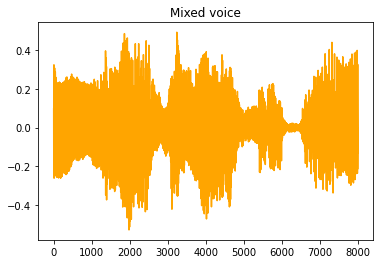

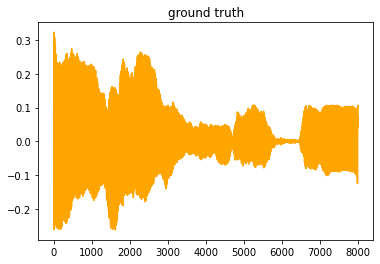

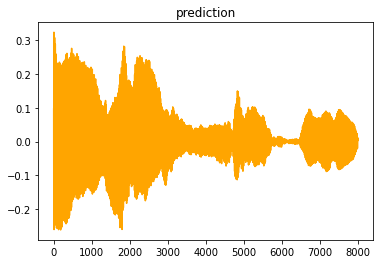

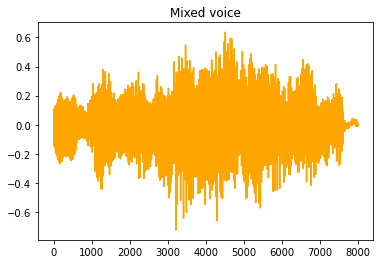

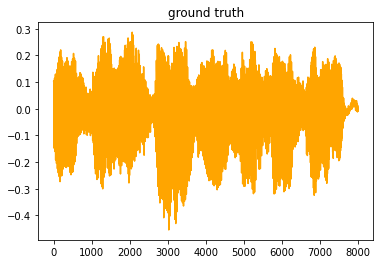

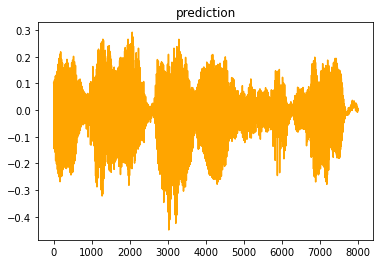

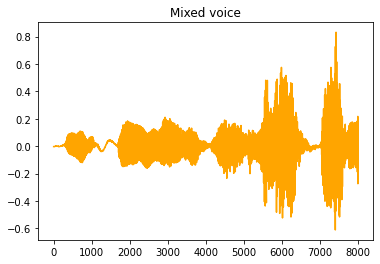

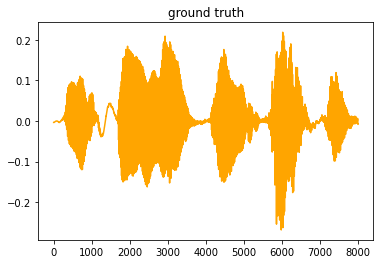

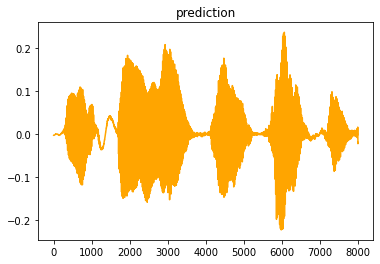

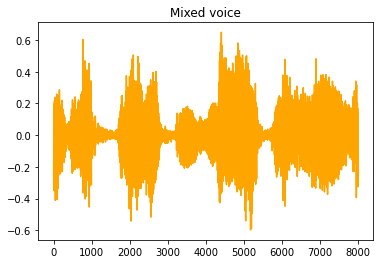

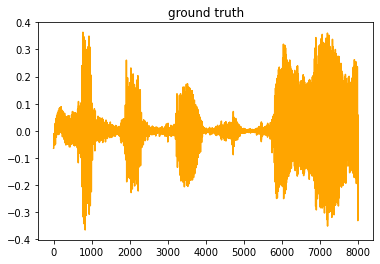

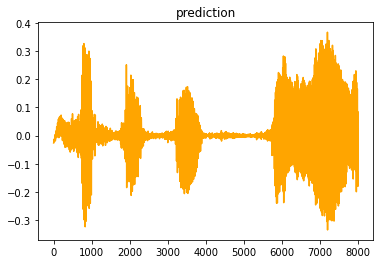

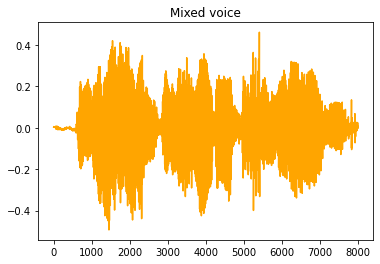

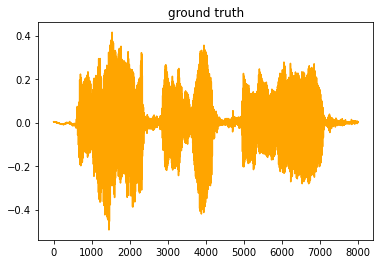

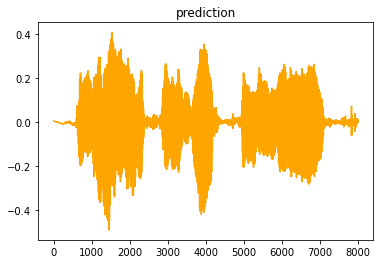

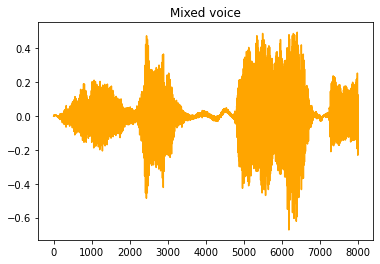

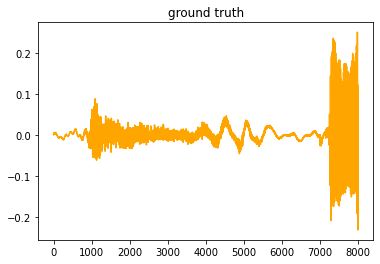

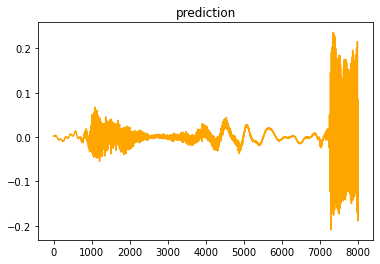

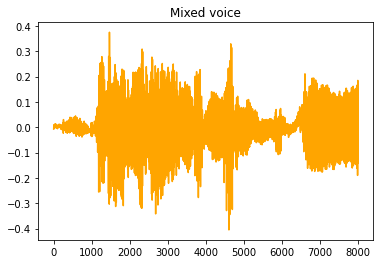

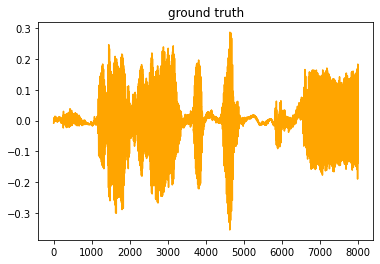

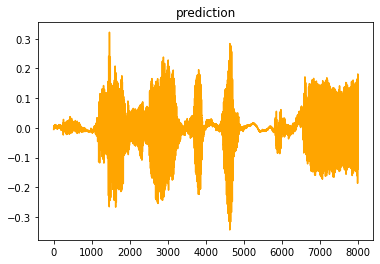

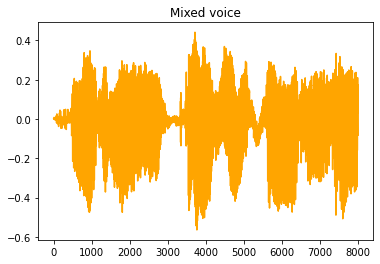

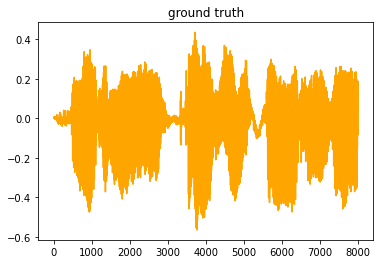

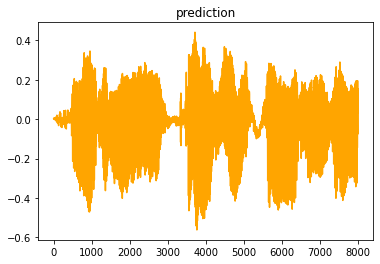

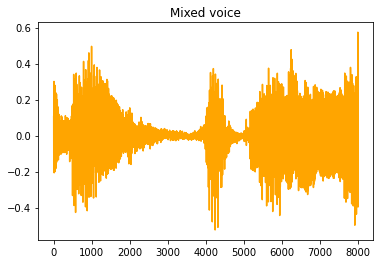

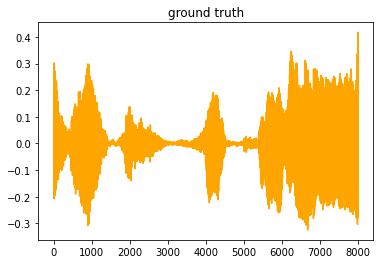

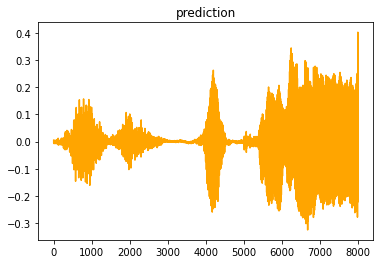

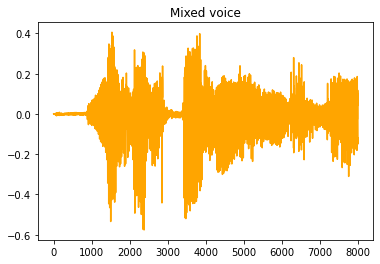

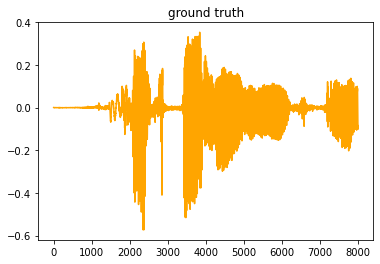

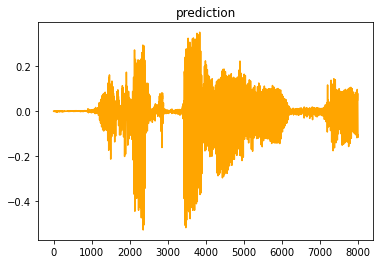

In [0]:
for i in range(20, 30):
  reconstruct_wav(X_test[i], test_phase[i], "Mixed voice")
  reconstruct_wav(y_test[i], test_phase[i], "ground truth")
  reconstruct_wav(test_res[i], test_phase[i], "prediction")